In [1]:
import warnings
warnings.filterwarnings("ignore")

from scipy import io
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

#this is your downloaded file
data = io.loadmat('mnist-original.mat')

x, y = data['data'].T, data['label'].T

#I split the data further down

In [2]:
print("Shape of X:", x.shape)
print("Shape of Y:", y.shape)
print("Unique values of Y:", np.unique(y))

Shape of X: (70000, 784)
Shape of Y: (70000, 1)
Unique values of Y: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


Based on the above, there are 10 classes in this dataset and 70,000 samples. 

**Visualize one element from each class.**

In order to visualize one element from each class, we'll need to get an index for one row of each class. Below, I've looked for the first row of each class.

Since we know that this is a dataset of images, we need to make the 1-D arrays of x (the images converted into arrays of RGB values) suitable for imaging by reshaping them into two dimensions. We can make the images into squares by taking the square root of 784, which is conveniently 28.

In [3]:
#making a list of the first index of each class
list_of_indices = list((np.nonzero(y == i)[0][0] for i in np.arange(0,10,1)))

#looping through indices above to make a list of reshaped arrays
list_of_images = list([x[i].reshape(28,28) for i in list_of_indices])

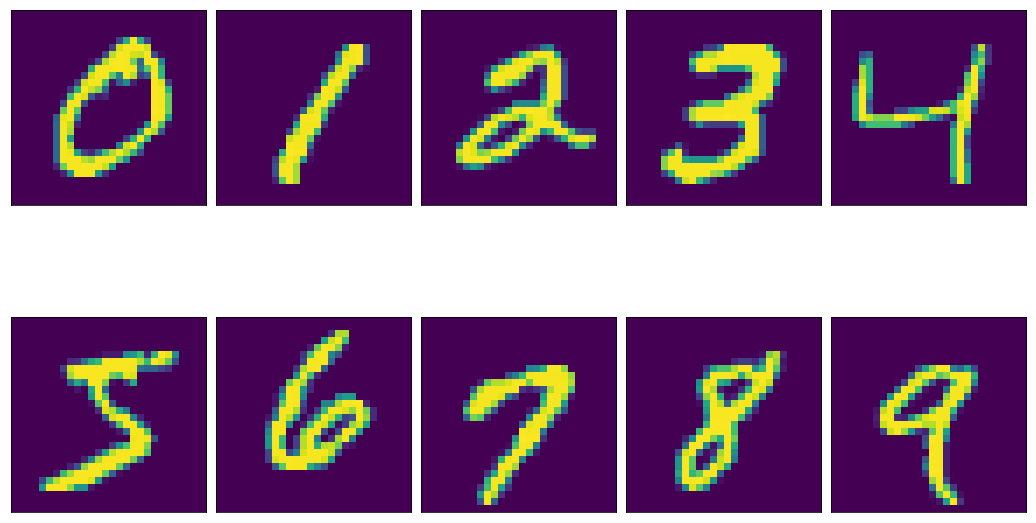

In [4]:
#plotting the arrays into a grid

grid = np.random.rand(4, 4)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

for ax, index in zip(axs.flat, list_of_images):
    ax.imshow(index)

**Visualize the mean of each class.**

One way to visualize the mean of each class is to get the arrays into a dataframe and group by the mean. We can then convert the resulting dataframe back into an array, reshape the arrays and plot again.

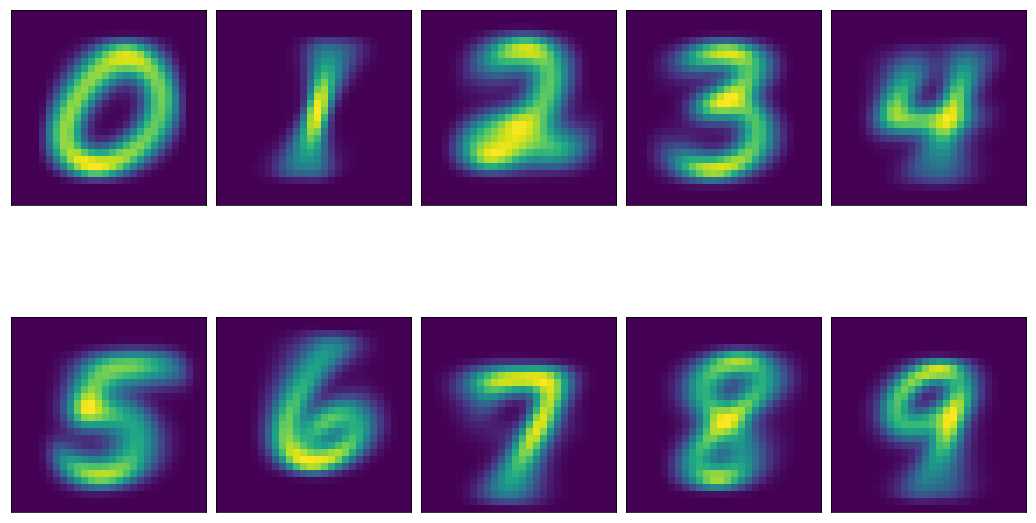

In [5]:
#convert arrays into dataframes and combine
dataframe_x=pd.DataFrame(x)
dataframe_y=pd.DataFrame(y)
dataframe_x['New_Index']=dataframe_y
dataframe_x.set_index('New_Index', inplace=True)

#group dataframe by mean of each class
grouped_data=dataframe_x.groupby('New_Index').mean()

#create list of image data
mean_images=[np.array(grouped_data)[i].reshape(28,28) for i in range(0,10,1)]

#plot image data from list
grid = np.random.rand(4, 4)

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.05)

for ax, index in zip(axs.flat, mean_images):
    ax.imshow(index)

As we can see, visualizing the mean of each number results in numbers that are much blurrier around the edges due to the variation across samples. However, the general shape of each number is still identifiable. This means, despite the variation, we should be able to classify a large range of handwritten numbers.

Below, I divide the values in each array by 255 to normalize them between 0 and 1. This will simplify things for when I want to use distanced-based computations like Principal Component Analysis. I also shrink the amount of data that I'm working with substantially to answer questions 3 and 4 in a reasonable time frame. Stratifying the first subset ensures that the same proportion of each class is kept intact.

In [6]:
#normalizing the data
normalized = x/255

#subsetting 30% of the data to make things workable
x_start, x_leftover, y_start, y_leftover = train_test_split(normalized, y, test_size=0.7, stratify=y, shuffle=True, random_state=1)

#using above subset to make train/validation/test split
x_train, x_test, y_train, y_test = train_test_split(x_start, y_start, test_size=0.5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5)

### Question 2###

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import timeit

**Try fitting a logistic regression with its solver set to be the 'lbfgs' algorithm. (If you'd like, you can try the other solvers/optimizers and observe the differences in computation time.)**

In [44]:
solver=["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
time=[]
training_scores=[]
validation_scores=[]
for i in solver:
    start=timeit.default_timer()
    log_regression = LogisticRegression(solver=i).fit(x_train,y_train)
    stop=timeit.default_timer()
    training_scores.append(log_regression.score(x_train, y_train))
    validation_scores.append(log_regression.score(x_val,y_val))
    time.append((i, stop-start))

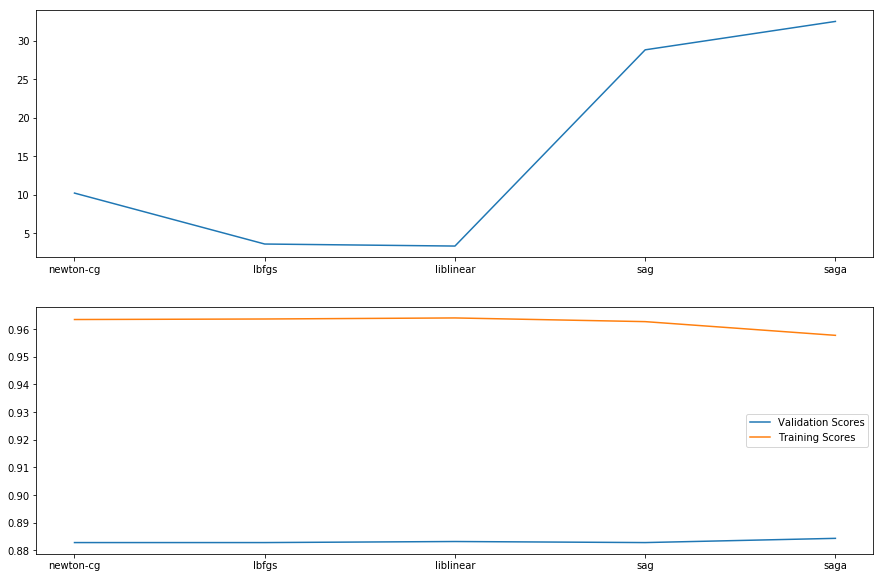

In [45]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10

time_plot=zip(*time)
ax1.plot(*time_plot)
ax2.plot(solver, validation_scores, label="Validation Scores")
ax2.plot(solver,training_scores, label="Training Scores")
ax2.legend()

It looks like 'liblinear', the default solver, is also the fastest by a small margin. According to [this explanation](https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions) on Stack Overflow, liblinear is recommended for high dimension datasets. The second fastest is 'lbfgs' and is best for small datasets, which makes sense because lbfgs is an estimation of the first method (newton-cg) and is stored in limited memory. Sag and Saga take a much longer time than the others, but these results would likely change were the dataset much larger since they're more effective on large scale datasets. Obviously careful consideration of a solver is important, and one needs to decide whether they want to prioritize time or accuracy when choosing one for their model. Based on the above, however, for this dataset and its size, the accuracy does not seem to vary much at all on either the training or validation sets. Since I've taken a fairly small subset of the data, I will use lbfgs for the remainder of this assignment when using logistic regression.

In [46]:
from sklearn.decomposition import PCA

time_pca=[]
PCA_train_scores=[]
PCA_val_scores=[]
#Build and fit a PCA model to the data
for i in range(1,500,10):
    my_pca = PCA(n_components=i)
    my_pca.fit(x_train)
    
    X_PCA = my_pca.transform(x_train)
    X_PCA_val = my_pca.transform(x_val)
    
    start=timeit.default_timer()
    log_regression = LogisticRegression(solver='lbfgs').fit(X_PCA,y_train)
    stop=timeit.default_timer()
    
    PCA_train_scores.append((i,log_regression.score(X_PCA, y_train)))
    PCA_val_scores.append((i,log_regression.score(X_PCA_val,y_val)))
    
    time_pca.append((i, stop-start))

Text(0.5, 0, 'PCA')

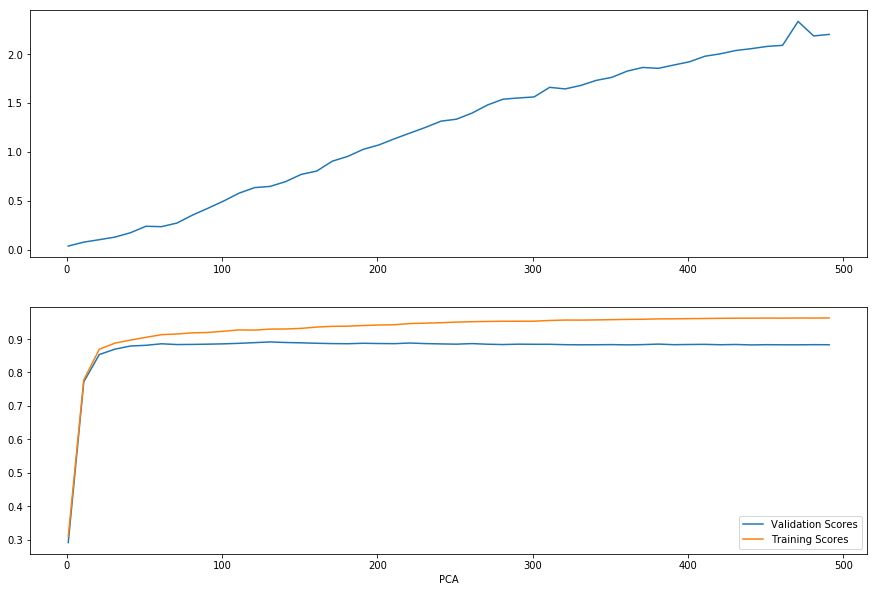

In [47]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10

time_plot=zip(*time_pca)
val_plot=(zip(*PCA_val_scores))
train_plot=zip(*PCA_train_scores)
ax1.plot(*time_plot)
ax2.plot(*val_plot, label="Validation Scores")
ax2.plot(*train_plot, label="Training Scores")
ax2.legend()
plt.xlabel("PCA")

**What does reducing the dimensionality do to the computation time and why?**

The run time increases linearly as we increase the number of PCA components. This is because a direction with the highest variance has to be calculated for each component. Accuracy doesn't seem to make huge improvements after about 25-30 components on this particular dataset, so there isn't much of a tradeoff between runtime and accuracy here.

In [14]:
time=[]
size_train_scores=[]
size_val_scores=[]

size_list=[0.95, 0.75, 0.5, 0.25, 0.05]

for i in size_list:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i)
    start=timeit.default_timer()
    log_regression = LogisticRegression(solver='lbfgs').fit(x_train,y_train)
    stop=timeit.default_timer()
    time.append((i, stop-start))
    
    size_train_scores.append((i,log_regression.score(x_train, y_train)))
    size_val_scores.append((i,log_regression.score(x_val,y_val)))
    
    time_pca.append((i, stop-start))

Text(0.5, 0, 'test size (in %)')

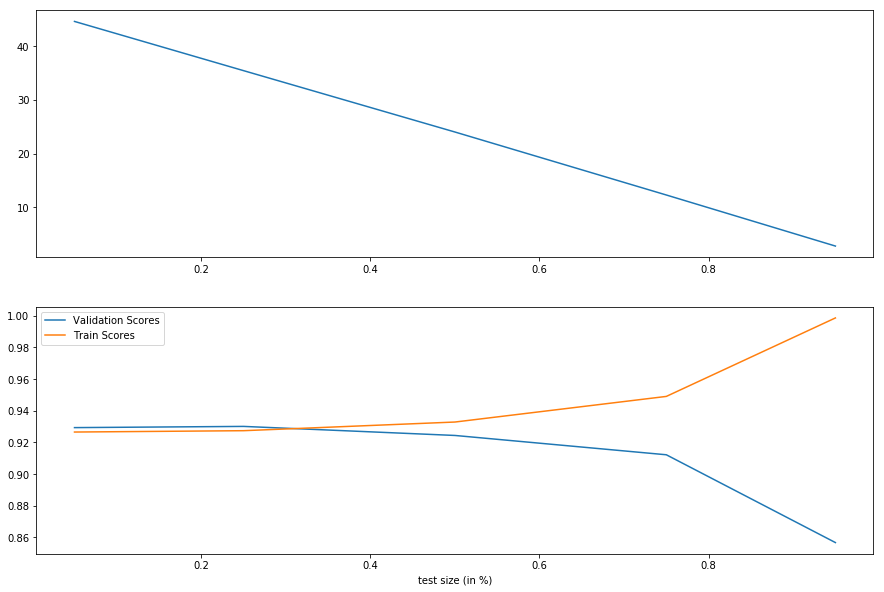

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

time_plot=zip(*time)
train_plot=zip(*size_train_scores)
val_plot=zip(*size_val_scores)
ax1.plot(*time_plot)
ax2.plot(*val_plot, label="Validation Scores")
ax2.plot(*train_plot, label="Train Scores")
plt.legend()
plt.xlabel("test size (in %)")

**What does reducing the number of data points do to the computation time and why?**

Reducing the number of data points speeds up the computation time. Since models are fit using the data itself, having fewer data points means fewer calculations have to be made to fit that model and thus the computation time is reduced.

**List one advantage and disadvantage of reducing dimensionality. List one advantage and disadvantage of reducing the number of data points.**
_Dimensionality:_ Reducing dimensionality can help remove unnecessary data that obscures the sources of change and variation between features. However, reducing dimensionality happens across the entire dataset rather than by feature, so it can reduce interpretability (if this is something you need in a model). It also has the potential to remove -some- important data in its process, so accuracy may drop compared to keeping all dimensions intact.

_Data Points:_ As we can see above, reducing the amount of data does help speed up computation time which may be an important factor when you don't have the time or the resources to run an extensive modelling process. However, we can see that as the test size increases (and the training size decreases, reducing the data points used to fit the model), the discrepancy between the training and validation accuracy increases substantially. A model will start to overfit (that is, it will start to "memorize" the data points it has available), will be less able to generalize and therefore will be less able to predict unseen data as the number of data points decreases. 

### Question 3: ###
**Use 5-fold cross-validation with a KNN classifier to model the data. Try various values of k (e.g. from 1 to 15) to find the ideal number of neighbors for the model.**

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [9]:
#fit model
validation_score_list = []
for i in range(1,50,2):
    myknn=KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
    
    validation_score = np.mean(cross_val_score(myknn, x_train, y_train, cv = 5))
    validation_score_list.append(validation_score)

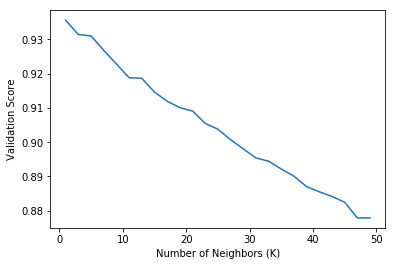

In [10]:
y_axis=range(1,50,2)
plt.plot(y_axis, validation_score_list)
plt.ylabel("Validation Score")
plt.xlabel("Number of Neighbors (K)")
plt.show();

In [15]:
neighbors_1=KNeighborsClassifier(n_neighbors = 1).fit(x_train,y_train)
np.mean(cross_val_score(neighbors_1, x_train, y_train, cv = 5))

0.9340942075536794

In [16]:
neighbors_max=KNeighborsClassifier(n_neighbors = 3146).fit(x_train,y_train)
np.mean(cross_val_score(neighbors_max, x_train, y_train, cv = 5))

0.19143668450461804

Increasing the number of K (neighbors) in the KNN classifier results in a consistent decline in predictive accuracy after about 8 neighbors (in this dataset). This is because increasing the number of neighbors will reduce the variance in the model, but will increase the bias by classifying each data point to smaller and more numerous groups. For example, when we look at the validation score on the max number of neighbors, only 19% are correctly predicted. When every data point is its own "neighbor", it is classified in its own category - this will not be useful when trying to classify unknown data. Deciding on a K ultimately comes down to the bias-variance tradeoff, and highlights the importance of using a validation set to tune the K accordingly.

### Decision Trees ###

In [11]:
from sklearn import tree

In [12]:
validation_score_list=[]

depth=range(1,30,1)

for i in depth:
    DT_model = tree.DecisionTreeClassifier(max_depth=i)
    DT_model.fit(x_train, y_train)
    validation_score = np.mean(cross_val_score(DT_model, x_train, y_train, cv = 5))
    validation_score_list.append(validation_score)

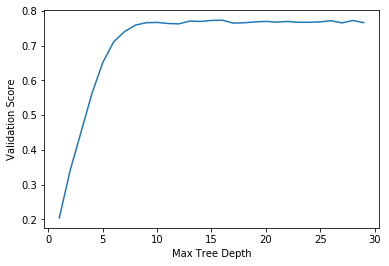

In [14]:
y_axis=range(1,30,1)
plt.plot(y_axis, validation_score_list)
plt.ylabel("Validation Score")
plt.xlabel("Max Tree Depth")
plt.show();

What we see here is essentially the opposite of the KNN, in that increasing tree depth increases the flexibility of the model and decreases bias. However, at a certain point the improvements in accuracy do not increase because the model has gotten as flexible as it can get for the data. Thus, the best depth for a decision tree for this dataset is probably 9 or 10, which makes sense since this dataset has 10 classes.

### Question Four ###

**Fit a linear model, such as logistic regression or an SVM (to speed up training you can modify the default settings). Try to get as high an accuracy as possible on a validation set.**

In [7]:
from sklearn.decomposition import PCA

Below I've chosen to reduce the number of dimensions of the model to 25, based upon the PCA accuracy plots above. 

In [8]:
pca = PCA(n_components=25)  
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)

As mentioned earlier, I am also using the lbfgs solver because it is the fastest for a smaller dataset and didn't sacrifice accuracy compared to the other options. Here I'll loop through values of the C parameter, which controls regularization (i.e. shrinking the coefficients of variables that do not contribute much to the model). 

In [16]:
validation_score_list=[]
value_range = [0.00001,0.0001,0.001,0.01,0.1,1,10,100, 1000,10000]

for i in value_range:
    log_regression = LogisticRegression(solver='lbfgs', C=i).fit(x_train_pca,y_train.ravel())
    validation_score = np.mean(cross_val_score(log_regression, x_train_pca, y_train.ravel(), cv = 5))
    validation_score_list.append((i,validation_score))
validation_score_list

[(1e-05, 0.30495495944744644),
 (0.0001, 0.6756383356432278),
 (0.001, 0.8005824883863365),
 (0.01, 0.8464960055629411),
 (0.1, 0.8647818142744903),
 (1, 0.8701133650228243),
 (10, 0.8699243414768192),
 (100, 0.8695439317630763),
 (1000, 0.8695439317630763),
 (10000, 0.8695439317630763)]

Here we see that accuracy reaches a peak where C=1 and decreases after - this is my best model.

In [10]:
log_regression = LogisticRegression(solver='saga', C=1).fit(x_train_pca,y_train.ravel())
y_pred=log_regression.predict(x_val_pca)

**What does the class confusion matrix look like for your best model? Is there anything that stands out in it?**

In [11]:
from sklearn.metrics import confusion_matrix
confusion_mat=confusion_matrix(y_val, y_pred)

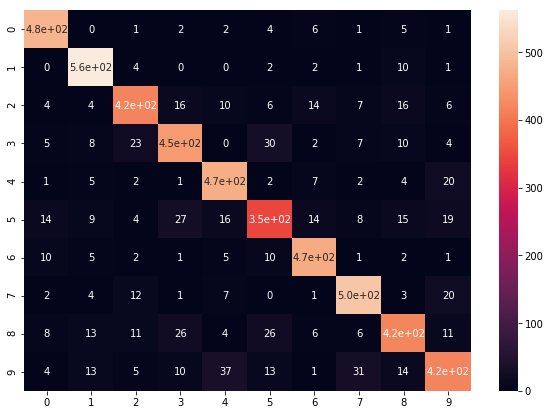

In [16]:
import seaborn as sn

df_cm = pd.DataFrame(confusion_mat, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

The model performs quite well (87% accuracy on the validation set), which is visualized here. The diagonal line through the center represents correct predictions, and brighter colors mean higher numbers -- so most digits were predicted correctly. Of the incorrect predictions, it seems like the model had the hardest time distinguishing between 4s and 9s (57 incorrect in total), 7s and 9s (51), 5s and 3s (also 57) and 5s and 8s (41).

Out of curiosity, I'll also try fitting a Support Vector Machine. Again, I'll loop through values of C:

In [16]:
from sklearn.svm import LinearSVC

In [60]:
training_score=[]
validation_score=[]

value_range = [0.0001,0.001,0.01,0.1,1,10]

for i in value_range:

    SVM_model = LinearSVC(C=i)
    SVM_model.fit(x_train,y_train)

    training_score.append((i,100 * SVM_model.score(x_train,y_train)))
    validation_score.append((i,100*SVM_model.score(x_val, y_val)))

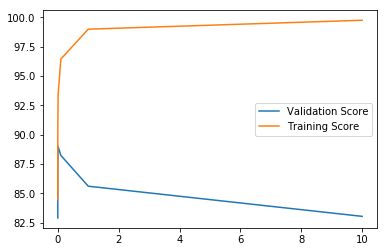

In [61]:
train_plot=zip(*training_score)
val_plot=zip(*validation_score)
plt.plot(*val_plot, label="Validation Score")
plt.plot(*train_plot, label="Training Score")
plt.legend()

It's hard to see where the validation score peaks, so I'll zoom in here:

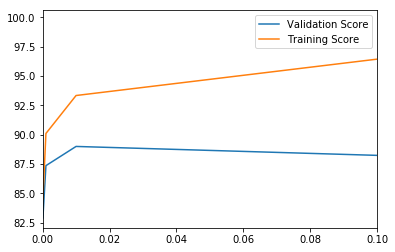

In [65]:
train_plot=zip(*training_score)
val_plot=zip(*validation_score)
plt.plot(*val_plot, label="Validation Score")
plt.plot(*train_plot, label="Training Score")
plt.xlim(0,0.1)
plt.legend()

The best model has a C value of 0.01, so I'll plot a confusion matrix for this instead:

In [17]:
SVM_model = LinearSVC(C=0.01)
SVM_model.fit(x_train,y_train.ravel())
y_pred=SVM_model.predict(x_val)

In [21]:
confusion_mat=confusion_matrix(y_val, y_pred)

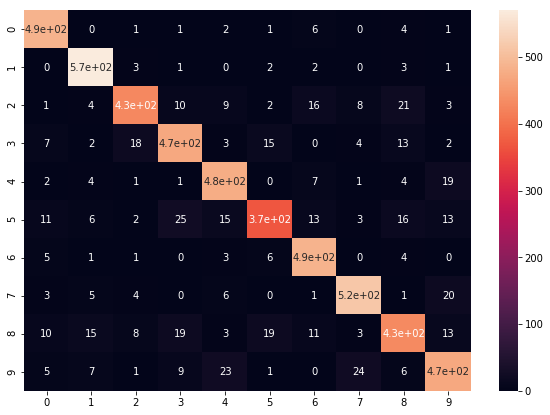

In [22]:
import seaborn as sn

df_cm = pd.DataFrame(confusion_mat, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

Like the logistic regression confusion matrix above, we see a line of color through the middle diagonally illustrating the excellent performance of the model. This model performs a little better on distinguishing between problem cases too.

**Re-fit a linear model that can discriminate between the digit 4 and the digit 9. Visualize the weights of the model as an image, does anything stand out?**

First, I'll isolate all of the 4s and 9s into one dataframe:

In [50]:
#getting indices of 4s and 9s
list_of_4 = list((np.nonzero(y == 4)[0]))
list_of_9 = list((np.nonzero(y==9)[0]))

dataframe_4_9=pd.concat([dataframe_x.iloc[list_of_4[0]:list_of_4[-1]], dataframe_x.iloc[list_of_9[0]:list_of_9[-1]]])

In [51]:
x_49=dataframe_4_9.values
y_49=dataframe_4_9.index

#splitting data into train, validate, test
x_train, x_test, y_train, y_test = train_test_split(x_49, y_49, test_size=0.5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5)

Here I'll loop through extremely small values of C to heavily penalize coefficients that do not perform well and see how the accuracy does on the validation set:

In [52]:
from sklearn.svm import LinearSVC

In [85]:
training_score=[]
validation_score=[]

value_range = [0.00000001,0.0000001,0.000001,0.00001]

for i in value_range:

    SVM_model = LinearSVC(C=i)
    SVM_model.fit(x_train,y_train)

    training_score.append((i,100 * SVM_model.score(x_train,y_train)))
    validation_score.append((i,100*SVM_model.score(x_val, y_val)))

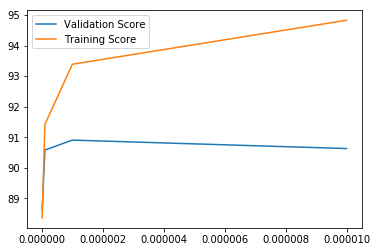

In [86]:
train_plot=zip(*training_score)
val_plot=zip(*validation_score)
plt.plot(*val_plot, label="Validation Score")
plt.plot(*train_plot, label="Training Score")
plt.legend()

It looks like the accuracy peaks at C=0.000001 at 91%, so we'll use this model:

In [87]:
SVM_model = LinearSVC(C=0.000001)
SVM_model.fit(x_train,y_train)
y_pred = SVM_model.predict(x_val)

Since there will be a coefficient for every independent variable (784 in total), we can take the square root and visualize the coefficients as an image:

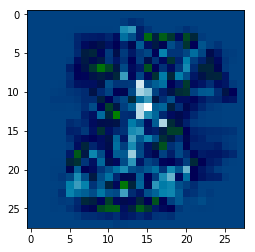

In [88]:
plt.imshow(SVM_model.coef_[1].reshape(28,28), cmap="ocean")

Since this is a linear model that is meant to discriminate between 4 and 9, this image of the coefficients is a representation of how the model differentiates between the two numbers. If we visualize the absolute difference between the mean images of 4 and 9 that were viewed above, a similar shape/silhouette can be expected:

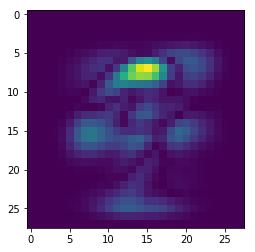

In [78]:
plt.imshow(abs(mean_images[9]-mean_images[4]))

While not identical (particularly around the lower third), there are definitely similarities between the two images that highlight the goal of model-building: to quantify specific differences between classes.

### Question 5 ###

Fitting the models using logistic regression and a linear SVM above reached a peak of about 88% accuracy on the validation set using optimal hyperparameters. Here I'll try out SVMs with different kernels to see if they are able to beat these scores at all:

In [14]:
from sklearn.svm import SVC

In [23]:
score_list=[]
kernel_list=[]
for i in ['linear', 'poly', 'rbf', 'sigmoid']:
    my_kernel_SVM = SVC(kernel=i)
    my_kernel_SVM.fit(x_train,y_train.ravel())
    validation_score = np.mean(cross_val_score(my_kernel_SVM, x_train, y_train.ravel(), cv = 5))
    score_list.append((i,validation_score))

In [24]:
score_list

[('linear', 0.9045701564687562),
 ('poly', 0.11142754523696094),
 ('rbf', 0.9022913360201699),
 ('sigmoid', 0.8803848205696759)]

It looks like the rbf kernel performs the best at 90% with 5-fold cross validation, so I'll loop through some gamma values and find the best value for this kernel:

In [8]:
score_list=[]
gamma=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
for i in gamma:
    my_kernel_SVM = SVC(kernel='rbf', gamma=i)
    my_kernel_SVM.fit(x_train,y_train)
    validation_score = np.mean(cross_val_score(my_kernel_SVM, x_train, y_train, cv = 5))
    score_list.append((i,validation_score))

In [15]:
score_list

[(1e-05, 0.1110472953946228),
 (0.0001, 0.7019101573679644),
 (0.001, 0.8979071047628697),
 (0.01, 0.9436301022008372),
 (0.1, 0.8101160660052267),
 (1.0, 0.1110472953946228),
 (10, 0.1110472953946228),
 (100, 0.1110472953946228),
 (1000, 0.1110472953946228)]

The gamma of 0.01 performs extremely well at 94%, but I'll get a little bit more granular to see if I can get even better results: 

In [23]:
score_list=[]
gamma=[0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
for i in gamma:
    my_kernel_SVM = SVC(kernel='rbf', gamma=i)
    my_kernel_SVM.fit(x_train,y_train.ravel())
    validation_score = np.mean(cross_val_score(my_kernel_SVM, x_train, y_train.ravel(), cv = 5))
    score_list.append((i,validation_score))

In [30]:
score_list

[(0.09, 0.8489462026591761),
 (0.08, 0.8900929796392617),
 (0.07, 0.9188569147980143),
 (0.06, 0.9394299508135904),
 (0.05, 0.9512410088444379),
 (0.04, 0.9558106641003074),
 (0.03, 0.9571421909699607),
 (0.02, 0.9527626470182419),
 (0.01, 0.9434361360239297)]

An rbf kernel with a gamma of 0.03 gives nearly 96% accuracy on the validation set. Let's run this model on the entire dataset and see how it performs. I'm going to use a test size of 40% based on the accuracy plot above on data size, as 40% is right around where the training and validation accuracy start to diverge.

### Creating the Final Model and Exporting to .pkl ###

In [25]:
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.svm import SVC
from scipy import io
from sklearn.model_selection import train_test_split

data = io.loadmat('mnist-original.mat')

x, y = data['data'].T, data['label'].T

normalized=x/255

x_train, x_test, y_train, y_test = train_test_split(normalized, y, test_size=0.40, random_state=1)

In [26]:
my_kernel_SVM = SVC(kernel='rbf', gamma=0.03)
my_kernel_SVM.fit(x_train,y_train.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Test score: 98.24 %


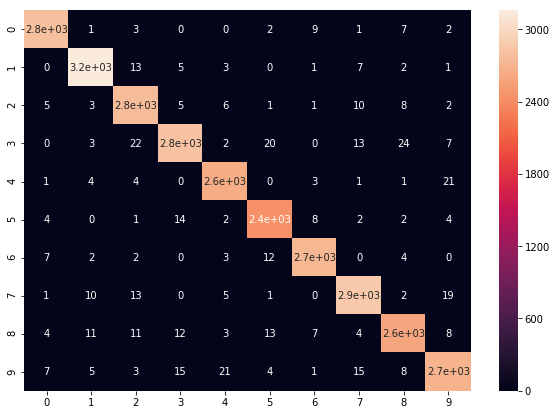

In [27]:
# Save to file in the current working directory
pkl_filename = "svm_model.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(my_kernel_SVM, file)

# Load from file
with open(pkl_filename, 'rb') as file:  
    my_kernel_SVM = pickle.load(file)

# Calculate the accuracy score and predict target values
score = my_kernel_SVM.score(x_test, y_test)  
print("Test score: {0:.2f} %".format(100 * score))  
y_pred = my_kernel_SVM.predict(x_test) 

#confusion matrix
confusion_mat=confusion_matrix(y_test, y_pred)

#visualizing confusion matrix
df_cm = pd.DataFrame(confusion_mat, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

This final model performed really well with 98% accuracy on the test set, and the confusion matrix highlights its success. As above, there's a clear diagonal line cutting through the center of the matrix that highlights that the vast majority of digits were correctly predicted to be themselves. A few of the problem pairs are the same as before - 4s and 9s (42 cases where they were predicted as the other),  7s and 9s (34), and 5s and 3s (34). Interestingly, this model did pretty well differentiating between 5s and 8s compared to the models used above. Also of note is that the absolute totals of incorrect have gone down, while the size of this dataset has gone up by a factor of 10. Ultimately, the linear logistic and SVM models worked pretty well but the non-linear SVM was extremely powerful in performing multi-classification. This exercise has also highlighted the efficacy of finely tuning hyperparameters on validation sets before running the model on the test set.